In [1]:
from numpy import log, sqrt, exp
from scipy.stats import norm
import numpy as np
np.set_printoptions(precision = 4)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# vanilla option
def option(S, K, T, v, r, q):
    
    call = {}
    put = {}
    
    ########## special case
    if hasattr(v, "__len__") or hasattr(T, "__len__"):
        if hasattr(v, "__len__") and v.any() == 0:
            raise "Try not to use 0 within array for v"
        if hasattr(T, "__len__") and T.any() == 0:
            raise "Try not to use 0 within array for T"    
            
    else:
        if v == 0 or T == 0:
            call['price'] = np.where(S>=K, S-K, 0)
            put['price'] = np.where(S<K, K-S, 0)
            call['delta'] = np.where(S>=K, 1, 0)
            put['delta'] = np.where(S<K, -1, 0)
            # still need completion
            
            if np.array(call['price']).size == 1:
                result = pd.DataFrame([call,put]).T
                result.columns = ['call','put']
                return result
            return call, put
    
    ########## normal case    
    sqrtT = sqrt(T)
    ert = exp(-r*T)
    eqt = exp(-q*T)

    d1 = (log(S/K) + (r-q+0.5*v**2)*T) / (v*sqrtT)
    d2 = d1 - v*sqrtT
    nd1 = norm.cdf(d1)
    nd2 = norm.cdf(d2)
    neg_nd1 = norm.cdf(-d1)
    neg_nd2 = norm.cdf(-d2)
    der_nd1 = norm.pdf(d1)

    call['price'] = S*nd1*eqt - K*nd2*ert
    put['price'] = - S*neg_nd1*eqt + K*neg_nd2*ert

    call['delta'] = eqt*nd1
    put['delta'] = eqt*(nd1-1)

    call['gamma'] = put['gamma'] = eqt*der_nd1 / (S*v*sqrtT)

    call['theta'] = -S*der_nd1*v*eqt/(2*sqrtT) + q*S*eqt*nd1 - r*K*ert*nd2
    put['theta'] = -S*der_nd1*v*eqt/(2*sqrtT) + q*S*eqt*neg_nd1 + r*K*ert*neg_nd2

    call['vega'] = put['vega'] = S * sqrtT * der_nd1* eqt

    call['rho'] = K*T*ert*nd2
    put['rho'] = -K*T*ert*neg_nd2
    
    if np.array(call['price']).size == 1:
        result = pd.DataFrame([call,put]).T
        result.columns = ['call','put']
        return result
    
    return call, put

In [3]:
S = 101
K = 98
T = 1
v = 0.32
r = 0.03
q = 0.02
option(S, K, T, v, r, q)

,call,put
price,14.381485,10.485081
delta,0.600236,-0.379963
gamma,0.011616,0.011616
theta,-6.241717,-3.833557
vega,37.918271,37.918271
rho,46.242306,-48.861357


In [4]:
# Vanilla Option with different K and T
S = 100
K = 100
T = np.arange(0.05, 1, 0.01)
v = 0.25
r = 0.03
q = 0

var = [90,100,110] ##### K variable
greektype = "delta"
linestyle = ['-','--','-.',':','.','*-','.-','s-','o-','^-']

len_var = len(var)
optiondata = [0] * len_var
greekdata = pd.DataFrame(T,columns=['T'])
for i,tmp in enumerate(var):
    K = tmp
    greekdata["K = " + str(K)] = option(S, K, T, v, r, q)[0][greektype]
greekdata = greekdata.set_index('T')

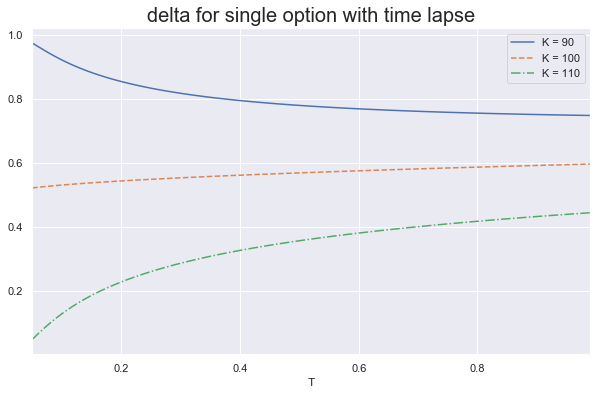

In [5]:
greekdata.plot(figsize = (10,6), style=linestyle[:len_var], legend = True)
plt.title(greektype + " for single option with time lapse", size = 20);

In [6]:
# Option Combination with different T

def greek(S, K, v, r, q, Tvar, greektype, combtype):
    len_Tvar = len(Tvar)
    greekdata = pd.DataFrame(S,columns=['S'])
    
    for i,tmp in enumerate(Tvar):
        T = tmp ##### T variable
        # single option
        if combtype == "single": 
            greekdata["T = " + str(T)] = option(S, K, T, v, r, q)[0][greektype]
        # straddle
        if combtype == "straddle": 
            greekdata["T = " + str(T)] = option(S, K, T, v, r, q)[0][greektype] + option(S, K, T, v, r, q)[1][greektype]
        # spread
        if combtype == "spread":
            spread = 5
            greekdata["T = " + str(T)] = option(S, K-spread, T, v, r, q)[0][greektype] - option(S, K+spread, T, v, r, q)[0][greektype]
        if combtype == "butterfly":
            butterfly = 5
            greekdata["T = " + str(T)] = option(S, K-butterfly, T, v, r, q)[0][greektype] - 2 * option(S, K, T, v, r, q)[0][greektype] + option(S, K+butterfly, T, v, r, q)[0][greektype]
        if combtype == "strangle":
            strangle = 5
            greekdata["T = " + str(T)] = option(S, K-strangle, T, v, r, q)[0][greektype] + option(S, K+strangle, T, v, r, q)[1][greektype]
    greekdata = greekdata.set_index('S')
    return greekdata

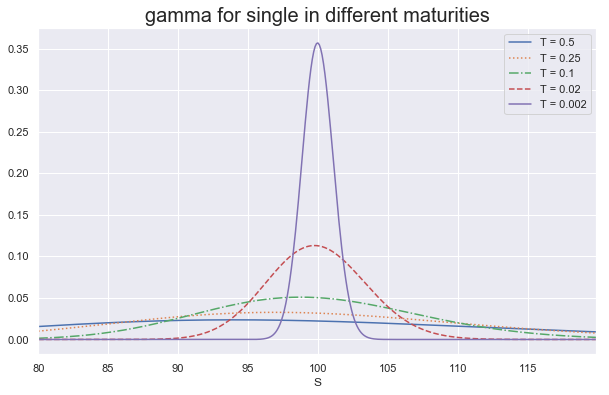

In [10]:
S = np.arange(80,120,0.1); K = 100; v = 0.25; r = 0.03; q = 0;
Tvar = [0.5, 0.25, 0.1, 0.02, 0.002] ##### T variable
len_var = len(Tvar)
greektype = "gamma" # price, delta, gamma, vega, theta, rho
combtype = "single" # single, straddle, spread, butterfly, strangle
linestyle = ['-',':','-.','--','-',':','-.','--','.-','s-','o-','^-']

gd = greek(S, K, v, r, q, Tvar, greektype, combtype)
gd.plot(figsize=(10,6), style=linestyle[:len_var], legend = True)
plt.title(greektype + " for " + combtype + " in different maturities", size = 20);

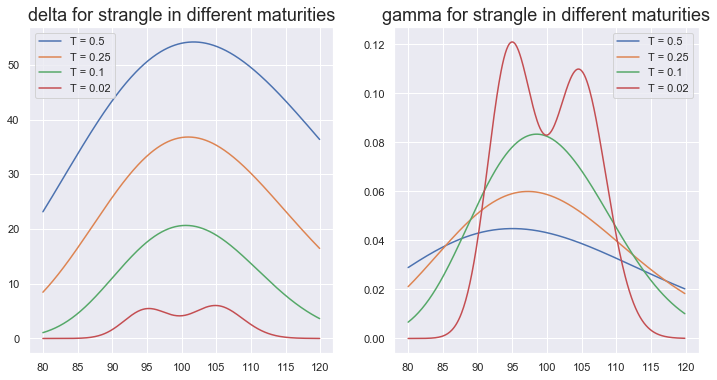

In [8]:
S = np.arange(80,120,0.1); K = 100; v = 0.25; r = 0; q = 0;
Tvar = [0.5, 0.25, 0.1, 0.02] ##### T variable
combtype = "strangle" # single, straddle, spread, butterfly, strangle

gd1 = greek(S, K, v, r, q, Tvar, "vega", combtype)
gd2 = greek(S, K, v, r, q, Tvar, "gamma", combtype)
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.plot(gd1)
ax1.set_title("delta for " + combtype + " in different maturities", size = 18)
ax1.legend(gd1.columns)

ax2.plot(gd2)
ax2.set_title("gamma for " + combtype + " in different maturities", size = 18)
ax2.legend(gd2.columns);

In [9]:
def find_max(array):
    l = len(array)
    pos = 0
    max = float("-inf")
    for i in range(l):
        if array[i] > max:
            max = array[i]
            pos = i
    return pos,max

In [18]:
for greek in gd:
    print(find_max(gd[greek].values),greek)

(140, 0.023635847257646378) T = 0.5
(170, 0.03266178633815263) T = 0.25
(188, 0.05093122284097445) T = 0.1
(198, 0.11303674389099752) T = 0.02
(200, 0.356803405463355) T = 0.002
